<a href="https://colab.research.google.com/github/albachiarabellaroba/HW3---Group-16/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework 3 - Places of the world**

*Authors: Bellaroba Albachiara, Mazza Ludovica, Jinjia Qian*

To get started, let's import all the libraries we will need.

In [3]:
from bs4 import BeautifulSoup
import bs4
import requests
import os.path
import lxml
import re
import codecs
import csv
import nltk
import pickle
import heapq
import numpy as np
from datetime import datetime
from tqdm import tqdm
import time
import pandas as pd
import spacy

In order to work in a faster environment, we link our work to a shared drive folder.

In [4]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


## 1. Data collection

### 1.1. Get the list of places

At this point we're creating a text file with all the link related to the 7200 places we will analyze.

In [ ]:
# NON runnare

linklist = open('/content/drive/MyDrive/ADM_HW3/linklist.txt', 'w')

for i in tqdm(range(1, 401)):
    link = f'https://www.atlasobscura.com/places?page={i}&sort=likes_count'
    cont = requests.get(link)
    soup = BeautifulSoup(cont.content, features='lxml')
    for a in soup.find_all('a', class_='content-card content-card-place'):
        linklist.write(a.get('href')+'\n')
        
linklist.close()

100%|██████████| 400/400 [02:05<00:00,  3.18it/s]


Control that we have all the link.

In [5]:
file = open('/content/drive/MyDrive/ADM_HW3/linklist.txt', 'r')
count=0
for i in file:
  if i != '\n':
    count += 1
file.close
print(count)

7200


Perfect, we have all the 7200 links we need to work so let's get started!

### 1.2. Crawl places

What we'll do in the following steps is necessary to store our data in correct way. 

In [ ]:
# NON runnare

def download(start, finish):
    header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    for i in tqdm(range(start, finish)):
      cart = '/content/drive/MyDrive/ADM_HW3/Html_page/page_{}'.format(i)
      os.makedirs(cart)
      
      f = open('/content/drive/MyDrive/ADM_HW3/linklist.txt', 'r', encoding='utf8')
      l = f.readlines()[(i-1)*18:(i)*18]
      l = [k.rstrip() for k in l]
      f.close

      m = 1+18*(i-1)

      for link in l:
        link = 'https://www.atlasobscura.com' + link
        html = requests.get(link, headers = header)
        if html.status_code != 200:
          time.sleep(200)
          html = requests.get(link, headers = header)


        name = '{}/{}.html'.format(cart, m)
        text = open(name, 'w', encoding='utf8')
        text.write(html.text)
        text.close
        m=m+1


In [ ]:
# NON runnare

download(1, 401)

100%|██████████| 100/100 [26:07<00:00, 15.67s/it]


### 1.3 Parse downloaded pages

In [ ]:
# NON runnare

placeName=[]
placeTags=[]
numPeopleVisited=[]
numPeopleWant=[]
placeDesc=[]
placeShortDesc=[]
placeNearby=[]
placeAddress=[]
placeAlt=[]
placeLong=[]
placeEditors=[]
placePubDate=[]
placeRelatedLists=[]
placeRelatedPlaces=[]
placeURL=[]

In [ ]:
# NON runnare

 for i in tqdm(range(1,401)):
   files = os.listdir('/content/drive/MyDrive/ADM_HW3/Html_page/page_'+str(i))
   for k in range(((18*(int(i)-1))+1), (18*int(i)+1)):
     file = open('/content/drive/MyDrive/ADM_HW3/Html_page/page_'+str(i)+'/'+str(k)+'.html', 'r', encoding='utf8')
     soup=bs4.BeautifulSoup(file, 'lxml')

     try:
       name=soup.find('h1', {'class':'DDPage__header-title'}).text
       placeName.append(name)
     except:
       placeName.append('')
         
     try:
       tag=soup.find_all('a', {'class':'itemTags__link js-item-tags-link'})
       tag=[i.get('href').split('/categories/')[1] for i in tag]
       placeTags.append(tag)
     except:
       placeTags.append('')
       
     try:
       visitors=soup.find_all('div', {'class':'title-md item-action-count'})[0].text.strip()
       numPeopleVisited.append(visitors)
     except:
       numPeopleVisited.append('')
    
     try:
       want=soup.find_all('div', {'class':'title-md item-action-count'})[1].text.strip()
       numPeopleWant.append(want)
     except:
       numPeopleWant.append('')

     try:
       desc=soup.find('div', {'class':'DDP__body-copy'}).text.strip()
       placeDesc.append(desc)
     except:
       placeDesc.append('')

     try:
       shdesc=soup.find('h3', {'class':'DDPage__header-dek'}).text.strip()
       placeShortDesc.append(shdesc)
     except:
       placeShortDesc.append('')

     try:
       nearby=soup.find_all('div', {'class':'DDPageSiderailRecirc__item-title'})
       nearby=[i.get_text() for i in nearby]
       placeNearby.append(nearby)
     except:
       placeNearby.append('')

     try:
       address=soup.find_all('address', {'class':'DDPageSiderail__address'})[0]
       address=address.find('div').get_text(separator=' ').split('\n')[0]
       placeAddress.append(address)
     except:
       placeAddress.append('')

     try:
       coordinates=soup.find_all('div', {'class':'DDPageSiderail__coordinates js-copy-coordinates'})[0].text.strip()
       p=coordinates.split(', ')
       placeAlt.append(p[0])
       placeLong.append(p[1])
     except:
       placeAlt.append('')
       placeLong.append('')

     try:
       editors=soup.find_all('div', {'class':'ugc-editor-icons'})
       editors=[i.findChildren('a')[0].get('href') for i in editors]
       editors=[k.split('/users/')[1] for k in editors]
       placeEditors.append(editors)
     except:
       placeEditors.append('')

     try:
       date=soup.find('div', {'class':'DDPContributor__name'}).text.strip()
       placePubDate.append(date)
     except:
       placePubDate.append('')

     try:
       rellist=soup.find_all('div', {'data-gtm-template':'DDP Footer Recirc Lists'})[0]
       rellist=[i.text.strip() for i in rellist.find_all('h3')]
       placeRelatedLists.append(rellist)
     except:
       placeRelatedLists.append('')

     try:
       relplaces=soup.find_all('div', {'class':'CardRecircSection__title'})
       relplaces=[i for i in relplaces if i.text == 'Related Places'][0]
       relplaces=relplaces.find_all_next('div', {'class':'Card__action-btns vue-js-been-there-everywhere-place'})
       relplaces=[k.get('data-place-title') for k in relplaces]
       placeRelatedPlaces.append(relplaces)
     except:
       placeRelatedPlaces.append('')

     try:
       url=soup.find('meta', attrs={'property':'og:url'})['content']
       placeURL.append(url)
     except:
       placeURL.append('')

100%|██████████| 400/400 [48:41<00:00,  7.30s/it]


In [ ]:
# NON runnare

features=pd.DataFrame(columns=['placeName', 'placeTags', 'numPeopleVisited', 'numPeopleWant', 'placeDesc', 'placeShortDesc',
                                            'placeNearby', 'placeAddress', 'placeAlt', 'placeLong', 'placeEditors', 'placePubDate', 
                                            'placeRelatedLists', 'placeRelatedPlaces', 'placeURL'], index=[1,7200])

for i in tqdm(range(0, 7200)):
  features.at[i, 'placeName'] = placeName[i]
  features.at[i, 'placeTags'] = placeTags[i]
  features.at[i, 'numPeopleVisited']= numPeopleVisited[i]
  features.at[i, 'numPeopleWant']= numPeopleWant[i]
  features.at[i, 'placeDesc']= placeDesc[i]
  features.at[i, 'placeShortDesc']= placeShortDesc[i]
  features.at[i, 'placeNearby']= placeNearby[i]
  features.at[i, 'placeAddress']= placeAddress[i]
  features.at[i, 'placeAlt']= placeAlt[i]
  features.at[i, 'placeLong']= placeLong[i]
  features.at[i, 'placeEditors']= placeEditors[i]
  features.at[i, 'placePubDate']= placePubDate[i]
  features.at[i, 'placeRelatedLists']= placeRelatedLists[i]
  features.at[i, 'placeRelatedPlaces']= placeRelatedPlaces[i]
  features.at[i, 'placeURL']= placeURL[i]
  

100%|██████████| 7200/7200 [00:23<00:00, 303.84it/s]


In [ ]:
# NON runnare
placesfeatures = features.to_csv('/content/drive/MyDrive/ADM_HW3/features.tsv', sep='\t', index=False)

Finally we have our dataframe.

In [6]:
visual=pd.read_csv('/content/drive/MyDrive/ADM_HW3/features.tsv', sep='\t')
visual = visual.drop(labels=[1], axis=0)
visual.head(5)

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL
0,Highgate Cemetery,"['rivals-week', 'vampires', 'hoaxes', 'occult'...",2625.0,8208.0,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.5675,-0.1483,['anthonyhogg'],"August 9, 2014","[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",http://www.atlasobscura.com/places/highgate-ce...
2,City Hall Station,"['subways', 'subterranean', 'infrastructure', ...",1834.0,8606.0,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"['rebekah-otto', 'annetta-black']","May 8, 2010",['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",http://www.atlasobscura.com/places/city-hall-s...
3,Leadenhall Market,"['markets', 'film-locations', 'film']",3142.0,7595.0,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.5126,-0.0834,"['meghanneal', 'gavin-292130']","August 1, 2016","['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",http://www.atlasobscura.com/places/leadenhall-...
4,The Wave Organ,"['sea-organ', 'aletrail', 'sounds', 'music', '...",2430.0,7425.0,"Located on a jetty in the San Francisco Bay, t...",A huge musical instrument played by the ocean.,"['Long Now Orrery', 'The Stern of the Briganti...","83 Marina Green Dr San Francisco, California, ...",37.8085,-122.4401,"['mbison', 'bylow1md']","November 21, 2008","[""Leonardo Nam's 16 Quirky Roadside Attraction...","['Sea Organ', 'Silent Green Kulturquartier', ""...",http://www.atlasobscura.com/places/wave-organ
5,Catacombes de Paris,"['ossuaries', 'memento-mori', 'catacombs-and-c...",4456.0,7057.0,"In 2004, Parisian police were assigned to do a...","The vast, legendary catacombs hold secrets muc...","['Sculptures de Décure', 'Arago Medallions', ""...","1 Place Denfert-Rochereau Paris, 75014 France",48.8343,2.3322,"['cpilgrim', 'akazem']","February 13, 2009","['19 Catacombs Sure to Tingle Your Spine', ""Th...","['Ossario di San Martino', 'Leuk Charnel House...",http://www.atlasobscura.com/places/catacombes-...


## 2. Search Engine

In [7]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import string

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Let's define a function that allows us to clean our descriptions

In [8]:
def clean(line):
  #split into token
  tokens = word_tokenize(line)
  #convert to lowercase
  tokens = [w.lower() for w in tokens]
  #remove punctuation
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  # remove remaining tokens that are not alphabetic or numeric (e.g. date or years can be usefull)
  words = [word for word in stripped if word.isalnum()]
  #filterout stopwords
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  #stemming
  ps = PorterStemmer()
  stem_sentence=[]

  for word in words:
    stem_sentence.append(ps.stem(word))

  return stem_sentence

Now to make things easier let's isolate the column we want to work on: DESCRIPTIONS

In [9]:
def vocabulary(visual):
    dic = {}
    contatore = 1
    for desc in tqdm(visual["placeDesc"]):
        #Cleaning the data
        desc = clean(str(desc))
        for word in desc:
            if word not in dic.keys():
              dic[word]=contatore
              contatore+=1
    return dic

In [11]:
vocabulary = vocabulary(visual)

100%|██████████| 7200/7200 [01:03<00:00, 113.04it/s]


In [ ]:
# NON runnare
with open('/content/drive/MyDrive/ADM_HW3/vocabulary.pkl', 'wb') as f:
  pickle.dump(vocabulary, f)

In [ ]:
# NON runnare
del vocabulary

In [12]:
with open('/content/drive/MyDrive/ADM_HW3/vocabulary.pkl', 'rb') as f:
  vocabulary=pickle.load(f)

In [13]:
print('In our vocabulary there are '+str(len(vocabulary))+' words.')

In our vocabulary there are 48986 words.


### 2.1.1 Create your index!

We have already created the vocabulary file as a dictionary in the last point of the exercise, now we need to invert the index and match the words in the dict with the words in the place's description.

In [14]:
import json
path='/content/drive/MyDrive/ADM_HW3'
with open (path+'vocabulary.json', 'w',encoding = 'utf-8') as j:
    j.write(json.dumps(vocabulary))

Here we create a list of all the cleaned description and we put it into the tsv file as a new column. That will help us when we will have to execute the query and return the place title and the url in the output.

In [15]:
list_clean_desc=[]

for i in visual.placeDesc:
  clean_desc=clean(str(i))
  list_clean_desc.append(clean_desc)

In [16]:
visual_copy=visual.copy()
visual_copy["list_clean_desc"]=list_clean_desc

visual_copy.head(3)

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL,list_clean_desc
0,Highgate Cemetery,"['rivals-week', 'vampires', 'hoaxes', 'occult'...",2625.0,8208.0,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.5675,-0.1483,['anthonyhogg'],"August 9, 2014","[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",http://www.atlasobscura.com/places/highgate-ce...,"[open, 1839, highgat, one, london, infam, ceme..."
2,City Hall Station,"['subways', 'subterranean', 'infrastructure', ...",1834.0,8606.0,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"['rebekah-otto', 'annetta-black']","May 8, 2010",['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",http://www.atlasobscura.com/places/city-hall-s...,"[first, new, york, citi, subway, built, oper, ..."
3,Leadenhall Market,"['markets', 'film-locations', 'film']",3142.0,7595.0,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.5126,-0.0834,"['meghanneal', 'gavin-292130']","August 1, 2016","['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",http://www.atlasobscura.com/places/leadenhall-...,"[ornat, 19thcenturi, paint, roof, cobbl, floor..."


In [ ]:
#NON RUNNARE

inverted_idx = {}

for word, item_id in vocabulary.items():
    inverted_idx[item_id] = list(visual_copy[visual_copy.list_clean_desc.apply(lambda row: word in row)].index)
  

In [ ]:
# NON runnare
with open('/content/drive/MyDrive/ADM_HW3/invertedidx.pkl', 'wb') as f:
  pickle.dump(inverted_idx, f)

In [ ]:
# NON runnare
del inverted_idx

In [17]:
with open('/content/drive/MyDrive/ADM_HW3/invertedidx.pkl', 'rb') as f:
  inverted_idx = pickle.load(f)

### 2.1.2 Execute the query

We are now defining a function that clean the query as we have cleaned the descriptions and then saves the index of the document that contains all the words of the given query in a list. We will then use this list to retrieve the final output of the search engine.

In [18]:
def output_id(query):
  c=query.split(' ')

  new_parole=[]
  for i in c:
    p = clean(i)
    new_parole.append(p[0])

  documents=[]
  for parola in new_parole:
    index_word= vocabulary[parola]
    docs= inverted_idx[index_word]
    documents.append(docs)

  fla_documents=[]
  for elem in documents:
    for num in elem:
      fla_documents.append(num)

  w=len(new_parole) #2
  output_places=[]

  for i in fla_documents:
    c = fla_documents.count(i)
    if c == w and i not in output_places:
      output_places.append(i)
  
  return output_places

Let's try the function and see if it works

In [19]:
query = 'American Museum'
print(output_id(query))
print(len(output_id(query)))

[60, 141, 174, 225, 321, 329, 358, 361, 417, 692, 785, 789, 893, 894, 961, 972, 974, 1007, 1039, 1052, 1075, 1091, 1101, 1110, 1123, 1126, 1163, 1199, 1204, 1234, 1249, 1261, 1331, 1355, 1365, 1387, 1401, 1414, 1418, 1485, 1541, 1544, 1554, 1557, 1582, 1588, 1626, 1701, 1738, 1766, 1777, 1802, 1804, 1805, 1858, 1859, 1888, 1902, 1970, 1996, 1999, 2058, 2072, 2078, 2088, 2110, 2138, 2167, 2191, 2221, 2223, 2236, 2276, 2280, 2286, 2364, 2418, 2468, 2559, 2561, 2579, 2596, 2653, 2662, 2665, 2670, 2726, 2737, 2744, 2795, 2826, 2956, 3009, 3053, 3081, 3089, 3168, 3170, 3217, 3263, 3274, 3354, 3369, 3375, 3397, 3410, 3417, 3418, 3420, 3517, 3615, 3687, 3698, 3713, 3722, 3757, 3775, 3795, 3811, 3827, 3832, 3896, 3969, 4011, 4044, 4057, 4098, 4099, 4104, 4269, 4295, 4297, 4320, 4376, 4393, 4396, 4405, 4416, 4423, 4430, 4449, 4459, 4473, 4490, 4500, 4512, 4533, 4542, 4546, 4548, 4554, 4563, 4634, 4676, 4691, 4735, 4766, 4778, 4784, 4787, 4864, 4933, 4948, 4952, 4965, 4987, 4995, 5066, 5070, 507

Now that we have the place_id that we want to print, let's find in the tsv file all the information we want to give in output.

In [21]:
def SearchEngine(query):
  pl = output_id(query)
  col = ['placeName', 'placeDesc', 'placeURL']
  df = pd.DataFrame(columns=col)
  df.placeName = [visual.placeName[i] for i in pl]
  df.placeDesc = [visual.placeDesc[i] for i in pl]
  df.placeURL = [visual.placeURL[i] for i in pl]
  return df

Give it a try!

In [22]:
frs = 'American Museum'
SearchEngine(frs)

,placeName,placeDesc,placeURL
0,The Witch House of Salem,The Salem witchcraft trials took place between...,http://www.atlasobscura.com/places/witch-house...
1,Museum of the Weird,The dime or dime store museum is by all accoun...,http://www.atlasobscura.com/places/museum-weird
2,National Atomic Testing Museum,Las Vegas is an oasis in the desert where no o...,http://www.atlasobscura.com/places/national-at...
3,Canyons of the Ancients,Ripe for quiet reflection and simply awe-inspi...,http://www.atlasobscura.com/places/canyons-of-...
4,The Natural Bridge,Often cited as having a place among the great ...,http://www.atlasobscura.com/places/the-natural...
...,...,...,...
238,De Vargas Street House,"Located in Santa Fe, New Mexico, the De Vargas...",http://www.atlasobscura.com/places/de-vargas-s...
239,The Liberty Bell Hiding Place,"In September of 1777, the British defeated Geo...",http://www.atlasobscura.com/places/liberty-bel...
240,Friendship Park,"On most days, San Diego’s Friendship Park is a...",http://www.atlasobscura.com/places/friendship-...
241,American Computer Museum,"“To collect, preserve, interpret, and display ...",http://www.atlasobscura.com/places/american-co...


## 2.2 Conjunctive query & Ranking score

### 2.2.1 Inverted index 2.0

In [ ]:
#tf-ij = # occorrenze del termine i nel documento j / lunghezza documento (num parole)

#idf-i = log10 ( #documenti in totale (7200) / #documenti che contengono il termine i (len(inverted_idx[parola])))

In [ ]:
# 1 : 2, 5 ,7   ----> 1 : {2 : 0,6} {5 : 0,012} {7 : 0,09}

In [ ]:
# NON runnare
from nltk.corpus.reader.ycoe import defaultdict
D=7200
inverted_idx_2 = defaultdict(dict)
for k, i in tqdm(vocabulary.items()):
  idf_i = np.log(D/len(inverted_idx[i]))
  for j in range(D):
    if k in list_clean_desc[j]:
      lung = len(list_clean_desc[j])
      freq = list_clean_desc[j].count(k)
      tf_ij = freq/lung
      tf_idf= tf_ij * idf_i
      inverted_idx_2[i].update({ j : tf_idf})

100%|██████████| 48986/48986 [25:12<00:00, 32.39it/s]


In [ ]:
# NON runnare
with open('/content/drive/MyDrive/ADM_HW3/invertedidx2.pkl', 'wb') as f:
  pickle.dump(inverted_idx_2, f)

del inverted_idx_2

In [23]:
with open('/content/drive/MyDrive/ADM_HW3/invertedidx2.pkl', 'rb') as f:
  inverted_idx_2 = pickle.load(f)

### 2.2.2 Execute the query

This function is an adaptation of the previous one. In this new version we use the inverted index 2.0 with the tfidf associated to each document for each word, and the output will be a list of index that corresponds to the document that compete for the last output.

In [24]:
def output_id2(query):
  c=query.split(' ')

  new_parole=[]
  for i in c:
    p = clean(i)
    new_parole.append(p[0])
  
  #add also the tfidf of the words in the query
  documents={}
  tf_idf_q={}
  N=visual.shape[0]
  for parola in new_parole:
    index_word= vocabulary[parola]
    docs= inverted_idx_2[index_word]
    documents[index_word]=docs
    tf_ij_q = new_parole.count(parola)
    idf_i_q = len(inverted_idx_2[index_word])
    tf_idf_q[index_word] = tf_ij_q * np.log(N/idf_i_q)

  fla_documents=list(documents.values())
  all_documents=[list(fla_documents[x].keys()) for x in range(len(fla_documents))]
  
  final_documents=[]
  for elem in all_documents:
    for num in elem:
      final_documents.append(num)

  w=len(new_parole) #2
  output_places2=[]

  for i in final_documents:
    c = final_documents.count(i)
    if c == w and i not in output_places2:
      output_places2.append(i)
  
  return output_places2, tf_idf_q

Let's give a try to see if the function actually works:

In [27]:
frase = 'American museum'
output_id2(frase)

In [28]:
def getNorm(id_desc, doc):
  word=doc[id_desc]
  total_tfidf=[]
  for par in word:
    idx = vocabulary[par]
    position = inverted_idx_2[idx]
    tfidf_par_doc = position[id_desc]
    total_tfidf.append(tfidf_par_doc)
  
  desc_norm = np.linalg.norm(total_tfidf)

  return desc_norm

Now we apply this function to all the description we have cleaned and stored in a list, and then create a new list which contains the ordered norm of each description.

In [29]:
norme = []
for descrizione in range(len(list_clean_desc)):
  norme.append(getNorm(descrizione, list_clean_desc))

An example to see if it works.

In [30]:
getNorm(69,list_clean_desc)

0.7665270630310047

In [31]:
def Classifica(query, k):
  candidati, tfidfquery = output_id2(query)
  classifica = []
  heapq.heapify(classifica)
  #per ogni documento candidato
  for doc in candidati:
    prodotti=[]
    #per ogni parola della query
    for parola in list(tfidfquery.keys()):
      tfidf_p = inverted_idx_2[parola]
      tfidf_pd = tfidf_p[doc]
      prodotti.append(tfidf_pd * tfidfquery[parola])
    #cosine similarity
    somma = sum(prodotti)
    cosine = somma/norme[doc]
    heapq.heappush(classifica, (cosine, doc))
    if len(classifica)==(k+1):
      heapq.heappop(classifica)

  return classifica

In [32]:
frase = 'american museum'

Classifica(frase, 5)

[(0.3377358950850909, 5269),
 (0.37954223152103844, 2664),
 (0.36005560482222176, 6209),
 (0.39238307158521707, 4472),
 (0.3964233975611651, 4994)]

Now let's try our search engine:

In [33]:
def searchEngine2(query, k):
  out=Classifica(query, k)

  col = ['placeName', 'placeDesc', 'placeURL', 'cosineSimilarity']
  df = pd.DataFrame(columns=col)
  
  i=0
  for cos, ind in out:
    df.at[i, 'placeName'] = visual.placeName[ind]
    df.at[i, 'placeDesc'] = visual.placeDesc[ind]
    df.at[i, 'placeURL'] = visual.placeURL[ind]
    df.at[i, 'cosineSimilarity'] = cos
    i+=1

  finito = df.sort_values(by=['cosineSimilarity'], ascending=False)

  return finito

In [34]:
frase = 'american museum'

searchEngine2(frase, 10)

,placeName,placeDesc,placeURL,cosineSimilarity
9,The Czech's Capuchin Crypt,The rosy pink facade of Brno’s Capuchin Church...,http://www.atlasobscura.com/places/czechs-capu...,0.396423
8,Hill of Witches,"Just off the main street in Juodkrante, Lithua...",http://www.atlasobscura.com/places/hill-of-wit...,0.392383
7,Cahokia Mounds,The largest pre-Columbian settlement in the Ne...,http://www.atlasobscura.com/places/cahokia-mounds,0.379542
3,Sea of Stars,The “Sea of Stars” is a beautiful phenomenon t...,http://www.atlasobscura.com/places/sea-of-stars,0.360056
4,Slope Point,"Slope Point, the most southerly spot on New Ze...",http://www.atlasobscura.com/places/slope-point,0.337736
1,Evergreen Memorial Park & Crematory,"Established in 1877, Evergreen Memorial Park a...",http://www.atlasobscura.com/places/evergreen-m...,0.32864
5,Crowley Mausoleum,"For over a century, the Crowley family owned t...",http://www.atlasobscura.com/places/crowley-mau...,0.308192
6,Ladder Creek Falls and Gardens,Ladder Creek Falls and Gardens in North Cascad...,http://www.atlasobscura.com/places/ladder-cree...,0.299304
2,The Miller Building,There’s no way to know how many reporters were...,http://www.atlasobscura.com/places/the-miller-...,0.281186
0,Thain Family Forest,This small forest in the Bronx could be the mo...,http://www.atlasobscura.com/places/thain-famil...,0.278352


## 3. Define a new score!

The new score we will use is based on adding some extra point to each document, starting from the cosine similarity score, based on this calculation:

*   +1 point if the city selected by the user (asked together with the query) is the same of the place.
*   +1 point for each tag contained in the placeTags that match a word of the query.

First of all we are going to clean the column placeAddress of our data frame in order to extract only the city name.

In [35]:
nlp = spacy.load('en_core_web_sm')

def city(indirizzi):
  doc = nlp(indirizzi)
  for ent in doc.ents:
    if ent.label_ == "GPE":
      return[''.join(ent.text)]

In [36]:
visual_copy.placeAddress = visual_copy.placeAddress.fillna('')
visual_copy.placeAddress.isnull().sum()

0

In [37]:
cities=[]
for i in visual_copy.placeAddress:
  citta=str(city(i)).lower()
  cities.append(citta)

Now for praticity we add a column to the data frame containing the cities.

In [38]:
visual_copy['Cities'] = cities

In [39]:
visual_copy.head(5)

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL,list_clean_desc,Cities
0,Highgate Cemetery,"['rivals-week', 'vampires', 'hoaxes', 'occult'...",2625.0,8208.0,"Opened in 1839, Highgate is one of London’s mo...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.5675,-0.1483,['anthonyhogg'],"August 9, 2014","[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",http://www.atlasobscura.com/places/highgate-ce...,"[open, 1839, highgat, one, london, infam, ceme...",['england']
2,City Hall Station,"['subways', 'subterranean', 'infrastructure', ...",1834.0,8606.0,The first New York City subway was built and o...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"['rebekah-otto', 'annetta-black']","May 8, 2010",['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",http://www.atlasobscura.com/places/city-hall-s...,"[first, new, york, citi, subway, built, oper, ...",['new york']
3,Leadenhall Market,"['markets', 'film-locations', 'film']",3142.0,7595.0,The ornate 19th-century painted roof and cobbl...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.5126,-0.0834,"['meghanneal', 'gavin-292130']","August 1, 2016","['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",http://www.atlasobscura.com/places/leadenhall-...,"[ornat, 19thcenturi, paint, roof, cobbl, floor...",['london']
4,The Wave Organ,"['sea-organ', 'aletrail', 'sounds', 'music', '...",2430.0,7425.0,"Located on a jetty in the San Francisco Bay, t...",A huge musical instrument played by the ocean.,"['Long Now Orrery', 'The Stern of the Briganti...","83 Marina Green Dr San Francisco, California, ...",37.8085,-122.4401,"['mbison', 'bylow1md']","November 21, 2008","[""Leonardo Nam's 16 Quirky Roadside Attraction...","['Sea Organ', 'Silent Green Kulturquartier', ""...",http://www.atlasobscura.com/places/wave-organ,"[locat, jetti, san, francisco, bay, wave, orga...",['san francisco']
5,Catacombes de Paris,"['ossuaries', 'memento-mori', 'catacombs-and-c...",4456.0,7057.0,"In 2004, Parisian police were assigned to do a...","The vast, legendary catacombs hold secrets muc...","['Sculptures de Décure', 'Arago Medallions', ""...","1 Place Denfert-Rochereau Paris, 75014 France",48.8343,2.3322,"['cpilgrim', 'akazem']","February 13, 2009","['19 Catacombs Sure to Tingle Your Spine', ""Th...","['Ossario di San Martino', 'Leuk Charnel House...",http://www.atlasobscura.com/places/catacombes-...,"[2004, parisian, polic, assign, train, exercis...",['paris']


In [40]:
def output_id3(query):
  c=query.split(' ')

  new_parole=[]
  for i in c:
    p = clean(i)
    new_parole.append(p[0])
  
  #add also the tfidf of the words in the query
  documents={}
  tf_idf_q={}
  N=visual.shape[0]
  for parola in new_parole:
    index_word= vocabulary[parola]
    docs= inverted_idx_2[index_word]
    documents[index_word]=docs
    tf_ij_q = new_parole.count(parola)
    idf_i_q = len(inverted_idx_2[index_word])
    tf_idf_q[index_word] = tf_ij_q * np.log(N/idf_i_q)

  fla_documents=list(documents.values())
  all_documents=[list(fla_documents[x].keys()) for x in range(len(fla_documents))]
  
  final_documents=[]
  for elem in all_documents:
    for num in elem:
      final_documents.append(num)

  w=len(new_parole) #2
  output_places2=[]

  for i in final_documents:
    c = final_documents.count(i)
    if c == w and i not in output_places2:
      output_places2.append(i)
  
  return output_places2, tf_idf_q

We will use the same function as before, but now after have calculated the cosine similarity we add other points based on our new ranking score.

In [41]:
def Classifica2(query, citta, k):
  candidati, tfidfquery = output_id3(query)
  classifica = []
  heapq.heapify(classifica)
  #per ogni documento candidato
  for doc in candidati:
    prodotti=[]
    #per ogni parola della query
    for parola in list(tfidfquery.keys()):
      tfidf_p = inverted_idx_2[parola]
      tfidf_pd = tfidf_p[doc]
      prodotti.append(tfidf_pd * tfidfquery[parola])
    #cosine similarity
    somma = sum(prodotti)
    cosine = somma/norme[doc]

    #add new points for the city
    citta=citta.lower()
    if visual_copy.Cities[doc] == citta:
      cosine = cosine + 1

    #add new points for the tags matching the query
    for parola in query:
      c = clean(parola)
      for t in visual_copy.placeTags[doc]:
        if c == t:
          cosine = cosine + 1

    heapq.heappush(classifica, (cosine, doc))
    if len(classifica)==(k+1):
      heapq.heappop(classifica)

  return classifica

In [44]:
def searchEngine3(query, citta, k):
  out=Classifica2(query, citta, k)

  col = ['placeName', 'placeDesc', 'placeURL', 'new_score']
  df = pd.DataFrame(columns=col)
  
  i=0
  for cos, ind in out:
    df.at[i, 'placeName'] = visual.placeName[ind]
    df.at[i, 'placeDesc'] = visual.placeDesc[ind]
    df.at[i, 'placeURL'] = visual.placeURL[ind]
    df.at[i, 'new_score'] = cos
    i+=1

  finito = df.sort_values(by=['new_score'], ascending=False)

  return finito

In [45]:
frase='bar pub'
citta='new york'

results = searchEngine3(frase, citta, 10)
results

,placeName,placeDesc,placeURL,new_score
7,Central Market,The oldest continuously operating farmers mark...,http://www.atlasobscura.com/places/central-market,1.742138
8,Waverly Hills Sanatorium,"Nestled on the top of a placid hill, the old W...",http://www.atlasobscura.com/places/waverly-hil...,1.502303
3,Jolly Green Giant Statue,Blue Earth may claim to be the birthplace of t...,http://www.atlasobscura.com/places/jolly-green...,1.411338
9,The Dominator Shipwreck,"On March 13, 1961, a Greek freighter called Th...",http://www.atlasobscura.com/places/the-dominat...,1.134015
6,Louis Valentino Jr. Park and Pier,The Louis Valentino Jr. Park-and-Pier in Red H...,http://www.atlasobscura.com/places/louis-valen...,1.116645
4,Saint Audoen's Gate,A great stone wall once hugged the edges of me...,http://www.atlasobscura.com/places/st-audoens-...,1.097795
1,Nan Madol Ruins,Off the coast of a remote Micronesian island l...,http://www.atlasobscura.com/places/nan-madol,1.068428
5,Bellocq Tea,You may not realize it was there even after ha...,http://www.atlasobscura.com/places/bellocq-tea,1.054383
2,Grand Staircase-Escalante National Monument,Named after its unique topography and impressi...,http://www.atlasobscura.com/places/grand-stair...,1.037517
0,The Junk Castle,"For a lot of artists, the 60s was a time of ex...",http://www.atlasobscura.com/places/the-junk-ca...,0.742223


## 4. Visualizing the most relevant places

In [47]:
import plotly.express as px

In [54]:
def searchEngine_tovisualize(query, citta, k):
  out=Classifica2(query, citta, k)

  col = ['placeName', 'placeDesc', 'placeURL', 'new_score','placeAlt','placeLong', 'numPeopleVisited','placeAddress']
  df = pd.DataFrame(columns=col)
  
  i=0
  for cos, ind in out:
    df.at[i, 'placeName'] = visual.placeName[ind]
    df.at[i, 'placeDesc'] = visual.placeDesc[ind]
    df.at[i, 'placeURL'] = visual.placeURL[ind]
    df.at[i, 'new_score'] = cos
    df.at[i, 'placeAlt'] = visual.placeAlt[ind]
    df.at[i, 'placeLong'] = visual.placeLong[ind]
    df.at[i, 'placeLong'] = visual.placeLong[ind]
    df.at[i, 'numPeopleVisited'] = visual.numPeopleVisited[ind]
    df.at[i, 'placeAddress'] = visual.placeAddress[ind]

    i+=1

  finito = df.sort_values(by=['new_score'], ascending=False)

  return finito

In [56]:
frase='bar pub'
citta='new york'

results_tovisualize = searchEngine_tovisualize(frase, citta, 10)
results_tovisualize

,placeName,placeDesc,placeURL,new_score,placeAlt,placeLong,numPeopleVisited,placeAddress
7,Central Market,The oldest continuously operating farmers mark...,http://www.atlasobscura.com/places/central-market,1.742138,40.0386,-76.3068,765.0,"23 North Market Street Lancaster, Pennsylvania..."
8,Waverly Hills Sanatorium,"Nestled on the top of a placid hill, the old W...",http://www.atlasobscura.com/places/waverly-hil...,1.502303,38.1307,-85.8414,573.0,"4400 Paralee Lane Louisville, Kentucky, 40272 ..."
3,Jolly Green Giant Statue,Blue Earth may claim to be the birthplace of t...,http://www.atlasobscura.com/places/jolly-green...,1.411338,43.6513,-94.0951,789.0,"Blue Earth, Minnesota, 56013 United States"
9,The Dominator Shipwreck,"On March 13, 1961, a Greek freighter called Th...",http://www.atlasobscura.com/places/the-dominat...,1.134015,33.7751,-118.4251,156.0,"Rocky Point Palos Verdes Estates, California, ..."
6,Louis Valentino Jr. Park and Pier,The Louis Valentino Jr. Park-and-Pier in Red H...,http://www.atlasobscura.com/places/louis-valen...,1.116645,40.6781,-74.0169,205.0,"Coffey Street and Ferris Street Brooklyn, New ..."
4,Saint Audoen's Gate,A great stone wall once hugged the edges of me...,http://www.atlasobscura.com/places/st-audoens-...,1.097795,53.344,-6.274,302.0,71-75 Cook St Dublin Ireland
1,Nan Madol Ruins,Off the coast of a remote Micronesian island l...,http://www.atlasobscura.com/places/nan-madol,1.068428,6.8404,158.3317,51.0,Micronesia
5,Bellocq Tea,You may not realize it was there even after ha...,http://www.atlasobscura.com/places/bellocq-tea,1.054383,40.7303,-73.9593,187.0,"104 West Street Brooklyn, New York, 11222 Unit..."
2,Grand Staircase-Escalante National Monument,Named after its unique topography and impressi...,http://www.atlasobscura.com/places/grand-stair...,1.037517,37.4,-111.6833,938.0,"Kane County Garfield County Kane, Utah United ..."
0,The Junk Castle,"For a lot of artists, the 60s was a time of ex...",http://www.atlasobscura.com/places/the-junk-ca...,0.742223,46.7577,-117.2321,125.0,"500-658 Armstrong Rd Pullman, Washington, 9916..."


In [57]:
dis = px.scatter_mapbox( results_tovisualize , lat='placeAlt', lon='placeLong', hover_name='placeName', 
                        hover_data=['numPeopleVisited', 'placeAddress'], color='numPeopleVisited', 
                        color_continuous_scale='algae', zoom=2, height=300)

dis.update_layout(mapbox_style='open-street-map')
dis.update_layout(margin={'r': 0 , 't' : 0 , 'l' : 0 , 'b' : 0})

dis.show()

## 5. BONUS: More complex search engine

## 7. Theoretical question

1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).

In [ ]:
with open('ApplicantsInfo.txt', 'x') as f:
    url = f'https://adm2022.s3.amazonaws.com/ApplicantsInfo.txt'
    result = requests.get(url)
    soup = bs(result.text)
    s = soup.find_all('body')
    f.write(str(s))

In [ ]:
Application = pd.read_csv('ApplicantsInfo.txt', header=None)

In [ ]:
n =Application.iloc[0]
Application.drop(0, inplace=True)
N= int(n[0][10:15])
M= int(n[0][16:20])

In [ ]:
newlist = []
students = []
average = []
for i in tqdm(range(N)):
    name = Application.iloc[i][0].split(' ')[0]
    surname = Application.iloc[i][0].split(' ')[1]
    grades = Application.iloc[i][0].split(' ')[2:]
    totalgrades = 0
    for i in grades:
        s = int(i)
        totalgrades += s
    avg = round(totalgrades/M,2)
    newlist.append((name, surname, avg))
    students.append((name, surname))
    average.append(avg)

100%|██████████| 50000/50000 [00:31<00:00, 1580.69it/s]


In [ ]:
newlist[1]

('Paula', 'Ahmadi', 24.02)

In [ ]:
students[1]

('Paula', 'Ahmadi')

In [ ]:
average[1]

24.02

bubbleSort( )

In [ ]:
def bubbleSort1(average, students):
    n = len(average)

    swap = False
    
    for i in range(N):
        
        for j in range(0, n-i-1):
 
            if average[j] > average[j + 1]:
                swap = True
                average[j], average[j + 1] = average[j + 1], average[j]
                students[j], students[j + 1] = students[j + 1], students[j]
         
        if not swap: 

            return

In [ ]:
bubbleSort1(average, students)

421.474s

In [ ]:
students[1]

('Bruce', 'Murphy')

In [ ]:
average[1]

23.54

In [ ]:
def bubbleSort2(newlist, average):
  n = len(average)
  
  swap = False
  
  for i in tqdm(range(n)):
    for j in range(0, n-i-1):
      if average[j] > average[j+1]:
        swap = True
        newlist[j], newlist[j+1] = newlist[j+1], newlist[j]

    if not swap: 
      
      return

In [ ]:
bubbleSort2(newlist, average)

100%|██████████| 50000/50000 [06:33<00:00, 127.21it/s] 


In [ ]:
newlist[1]

('Paula', 'Ahmadi', 24.02)

In [ ]:
average[1]

24.02

393.41s

MergeSort( )

In [ ]:
newlist[1]

('Paula', 'Ahmadi', 24.02)

In [ ]:
students[1]

In [ ]:
average[1]

24.02

In [ ]:
def merge(nam, arr, l, m, r): 
    n1 = m - l + 1
    n2 = r- m 
  
    L1 = L2 = [0] * (n1)
    R1 = R2 = [0] * (n2)
  
    for i in range(0 , n1): 
        L1[i] = arr[l + i] 
        L2[i] = nam[l + i] 
  
    for j in range(0 , n2): 
        R1[j] = arr[m + 1 + j] 
        R2[j] = nam[m + 1 + j] 
  
    i = 0
    j = 0
    k = l
  
    while i < n1 and j < n2 : 
        if L1[i] <= R1[j]: 
            arr[k] = L1[i]
            nam[k] = L2[i]  
            i += 1
        else: 
            arr[k] = R1[j]
            nam[k] = R2[j] 
            j += 1
        k += 1
  
    while i < n1: 
        arr[k] = L1[i]
        nam[k] = L2[i] 
        i += 1
        k += 1
  
    while j < n2: 
        arr[k] = R1[j]
        nam[k] = R2[j] 
        j += 1
        k += 1

        return

In [ ]:
def MergeSort1(nam, arr,l,r): 
    if l < r: 

        m = int((l+(r-1))/2)

        MergeSort1(nam, arr, l, m) 
        MergeSort1(nam, arr, m+1, r) 
        merge(nam, arr, l, m, r)
        
        return

In [ ]:
n = len(average)

MergeSort1(students, average, 0, n-1)

In [ ]:
students[1]

('Aaron', 'Aste')

In [ ]:
average[1]

23.63

In [ ]:
def MergeSort2(newlist, average):
    if len(average) > 1:
 
        mid = len(average)//2
 
        left_avg = average[:mid]
        left_list = newlist[:mid]
 
        right_avg = average[mid:]
        right_list = newlist[mid:]
 
        MergeSort2(left_avg, left_list)
 
        MergeSort2(right_avg, right_list)
 
        i = j = k = 0
 
        while i < len(left_avg) and j < len(right_avg):
            if left_avg[i] <= right_avg[j]:
                average[k] = left_avg[i]
                newlist[k] = left_list[i]
                i += 1
            else:
                average[k] = right_avg[j]
                newlist[k] = right_list[j]
                j += 1
            k += 1
 
        while i < len(left_avg):
            average[k] = left_avg[i]
            newlist[k] = left_list[i]
            i += 1
            k += 1
 
        while j < len(right_avg):
            average[k] = right_avg[j]
            
            newlist[k] = right_list[j]
            j += 1
            k += 1

            return

In [ ]:
MergeSort2(newlist, average)

In [ ]:
from heapq import merge

In [ ]:
def mergesort(arr1, arr2):
    if len(arr2) > 1:
        mid = len(arr2)//2

        leftarr1 = arr1[:mid]
        leftarr2 = arr2[:mid]

        rightarr1 = arr1[mid:]
        rightarr2 = arr2[mid:]

        mergesort(leftarr1, leftarr2)
        mergesort(rightarr1, rightarr2)
        
        i = 0
        k = 0
        j = 0
        while i < len(leftarr2) and j < len(rightarr2):
            if leftarr2[i] <= rightarr2[j]:
                arr2[k] = leftarr2[i]
                arr1[k] = leftarr1[i]
                i += 1
            else:
                arr2[k] = rightarr2[j]
                arr1[k] = rightarr1[j]
                j+=1
            k += 1
        
        while i < len(leftarr2):
            arr2[k] = leftarr2[i]
            arr1[k] = leftarr1[i]
            i += 1
            k += 1
        
        while j < len(rightarr2):
            arr2[k] = rightarr2[j]
            arr1[k] = rightarr1[j]
            
            j += 1
            k += 1
        
    return

In [ ]:
mergesort(students, average)

In [ ]:
students[1]

('Bruce', 'Murphy')

In [ ]:
average[1]

23.54

QuickSort( )

In [ ]:
newlist[1]

('Paula', 'Ahmadi', 24.02)

In [ ]:
students[1]

('Paula', 'Ahmadi')

In [ ]:
average[1]

24.02

In [ ]:
def QuickSort1(newlist, students, average, start, end):
    if start >= end:
        return
    mid = average[start]
    left = start
    right = end
    while left < right:
        while left < right and average[right] >= mid:
            right -= 1
        average[left] = average[right]
        newlist[left] = newlist[right]

        while left < right and average[left] < mid:
            left += 1

        average[right] = average[left]
        newlist[left] = newlist[right]

    average[left] = mid

    QuickSort1(average, start, left-1)

    QuickSort1(average, left+1, end)

In [ ]:
def partition(arr,li,left,right):  
    tmp = li[left]
    while left < right:
        while left < right and li[right] >= tmp:
            right -= 1
        li[left] = li[right]
        arr[left] = arr[right]
        
        while left < right and li[left] <= tmp:
            left += 1
        li[right] = li[left]
        arr[left] = arr[right]

    li[left] = tmp
    return  left

In [ ]:
def QuickSort2(arr,li,left,right):  
    if left < right :
        mid = partition(arr,li,left,right)
        QuickSort2(arr,li,left,mid-1)
        QuickSort2(arr,li,mid+1,right)

In [ ]:
import sys
sys.setrecursionlimit(1000000)


In [ ]:
sys.getrecursionlimit()

1000000

In [ ]:
QuickSort2(students,average,0,len(average)-1)

In [ ]:
students[1]

('Mary', 'Thompson')

In [ ]:
average[1]

23.54

2. What is the time complexity of each algorithm you have used?

BubbleSort

Bubble sort has a total of (n-1) cycles, and each cycle requires the current n-1 comparisons, so the total number of comparisons is:
(n-1) + (n-2) + (n-3) + … + 1 = n*(n-1)/2;
So the time complexity of bubble sort is O(n2)

MergeSort

Merge sort on n elements can be seen as merge sort on two sets of n/2 elements and call the Merge function once, so:

T(n)=2T(n/2)+an=4T(n/4)+2an=…=2kT(n/2k)+k

until n/2k=1

Then T(n)=2kT(1)+k=n+a*(log2n)n

The time complexity is O(nlogn)

QuickSort

in the best case

Partition is divided evenly every time. If n keywords are sorted, the depth of the recursive tree is log ⁡ 2 ( 2 n + 1 ) , the number of nodes is n \log_2(2n+1), and the number of nodes is nlog2(2n+1), the number of nodes is n

For example 2 nodes with a depth of 2.

The first Partiation should be to scan the entire array and do n comparisons.

The obtained pivot divides the array into two, then each requires T(n/2) time (note that it is the best case, so the two halves are equally divided) into 2 pieces: T ( n ) ≤ 2 T ( n / 2 ) + n , T ( 1 ) = 0 , where n = ( log ⁡ 2 2 ) × n is divided into 2 blocks: T(n) ≤ 2T(n/2) +n, T(1)=0, where n= (\log_22)\times n
Divided into 2 blocks: T(n)≤2T(n/2)+n, T(1)=0, where
n=(log2/2)×n

Continuing to divide, we have the following inequality inference
Divide into 4 pieces: T ( n ) ≤ 2 ( 2 T ( n / 4 ) + n / 2 ) + n = 4 T ( n / 4 ) + 2 n , where 2 n = ( log ⁡ 2 4 ) × n divide 4 blocks: T(n)≤2(2T(n/4)+n/2) +n=4T(n/4)+2n, where 2n=(\log_24)\times n
Divided into 4 blocks: T(n)≤2(2T(n/4)+n/2)+n=4T(n/4)+2n,
where 2n=(log2/4)×n

Divided into 8 pieces: T(n) ≤ 4 ( 2 T(n/8) + n/4) + 2 n = 8 T(n/8) + 3 n... Divided into 8 pieces: T(n) ≤ 4( 2T(n/8)+n/4)+2n=8T(n/8)+3n  …
Divided into 8 blocks: T(n)≤4(2T(n/8)+n/4)+2n=8T(n/8)+3n…

Divide into n pieces: T ( n ) ≤ n T ( 1 ) + ( log ⁡ 2 n ) × n = O ( n log ⁡ 2 n ) Divide into n pieces: T(n)≤nT(1)+(\log_2n) ×n= O(n\log_2n)
Divided into n blocks: T(n)≤nT(1)+(log
2
​
 n)×n=O(nlog
2
​
 n)

That is to say, in the optimal case, the time complexity of the quicksort algorithm is O(nlogn).

The sequence to be sorted is in positive or reverse order. Each division only gets a subsequence with one record less than the previous division. Note that the other is empty. If the recursion tree is drawn, it is a sloping tree.

At this time, n-1 recursive calls need to be performed, and the i-th division requires n-i keyword comparisons to find the i-th record, which is the position of the pivot, so the number of comparisons is
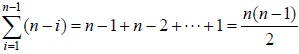
The time complexity is O(n^2).

3.Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.

In [ ]:
import matplotlib.pyplot as plt

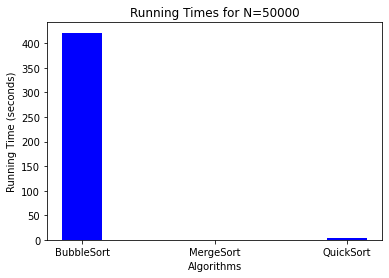

In [ ]:
algorithms = ['BubbleSort', 'MergeSort', 'QuickSort']
times = [421.474, 0.382, 3.192]

plt.bar(algorithms, times, color ='blue', width = 0.3)

plt.xlabel("Algorithms")
plt.ylabel("Running Time (seconds)")
plt.title("Running Times for N=50000")
plt.show()

4.What is the most optimal algorithm, in your opinion, and why?

**MergeSort**

Time complexity.

5.Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.